In [1]:
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter('ignore')

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
from datetime import timedelta
from tqdm import tqdm
sns.set()
tf.compat.v1.random.set_random_seed(1234)

In [12]:
df = pd.read_csv('C:/Users/ywen/Desktop/ML Python files/TSLA.csv')
df.head()

,date,1. open,2. high,3. low,4. close,5. volume
0,2021-02-22 20:00:00,710.60,710.99,710.50,710.610,11067.0
1,2021-02-22 19:59:00,710.82,710.85,710.50,710.600,8962.0
2,2021-02-22 19:58:00,711.01,711.01,710.80,710.905,3921.0
3,2021-02-22 19:57:00,710.82,711.20,710.82,711.170,8101.0
4,2021-02-22 19:56:00,710.70,711.00,710.70,710.800,4141.0


In [13]:
df.describe()

,1. open,2. high,3. low,4. close,5. volume
count,7302.000000,7302.000000,7302.000000,7302.000000,7302.000000
mean,803.587545,804.018302,803.140553,803.569716,31771.643522
std,35.262430,35.246988,35.290893,35.272773,50121.483976
min,710.600000,710.850000,709.000000,710.310000,103.000000
25%,784.945000,785.205000,784.500000,784.912500,1531.250000
50%,801.900000,802.056350,801.520000,801.900000,16494.500000
75%,817.137500,817.822500,816.882500,817.087500,41728.250000
max,877.000000,877.880000,876.000000,877.000000,954095.000000


In [14]:
minmax = MinMaxScaler().fit(df.iloc[:, 4:5].astype('float32')) # Close index
df_log = minmax.transform(df.iloc[:, 4:5].astype('float32')) # Close index
df_log = pd.DataFrame(df_log)
df_log.head()

,0
0,0.001800
1,0.001740
2,0.003570
3,0.005159
4,0.002940


In [20]:
test_size = 360
simulation_size = 1

df_train = df_log.iloc[:-test_size]
df_test = df_log.iloc[-test_size:]
df.shape, df_train.shape, df_test.shape

((7302, 6), (6942, 1), (360, 1))

In [21]:
class Model:
    def __init__(
        self,
        learning_rate,
        num_layers,
        size,
        size_layer,
        output_size,
        forget_bias = 0.1,
    ):
        def lstm_cell(size_layer):
            return tf.compat.v1.nn.rnn_cell.LSTMCell(size_layer, state_is_tuple = False)

        rnn_cells = tf.compat.v1.nn.rnn_cell.MultiRNNCell(
            [lstm_cell(size_layer) for _ in range(num_layers)],
            state_is_tuple = False,
        )
        self.X = tf.compat.v1.placeholder(tf.float32, (None, None, size))
        self.Y = tf.compat.v1.placeholder(tf.float32, (None, output_size))
        drop = tf.compat.v1.nn.rnn_cell.DropoutWrapper(
            rnn_cells, output_keep_prob = forget_bias
        )
        self.hidden_layer = tf.compat.v1.placeholder(
            tf.float32, (None, num_layers * 2 * size_layer)
        )
        self.outputs, self.last_state = tf.compat.v1.nn.dynamic_rnn(
            drop, self.X, initial_state = self.hidden_layer, dtype = tf.float32
        )
        self.logits = tf.compat.v1.layers.dense(self.outputs[-1], output_size)
        self.cost = tf.reduce_mean(tf.square(self.Y - self.logits))
        self.optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate).minimize(
            self.cost
        )
        
def calculate_accuracy(real, predict):
    real = np.array(real) + 1
    predict = np.array(predict) + 1
    percentage = 1 - np.sqrt(np.mean(np.square((real - predict) / real)))
    return percentage * 100

def anchor(signal, weight):
    buffer = []
    last = signal[0]
    for i in signal:
        smoothed_val = last * weight + (1 - weight) * i
        buffer.append(smoothed_val)
        last = smoothed_val
    return buffer

In [22]:
num_layers = 1
size_layer = 128
timestamp = 5
epoch = 300
dropout_rate = 0.8
future_day = test_size
learning_rate = 0.01

In [23]:
def forecast():
    tf.compat.v1.reset_default_graph()
    modelnn = Model(
        learning_rate, num_layers, df_log.shape[1], size_layer, df_log.shape[1], dropout_rate
    )
    sess = tf.compat.v1.InteractiveSession()
    sess.run(tf.compat.v1.global_variables_initializer())
    date_ori = pd.to_datetime(df.iloc[:, 0]).tolist()

    pbar = tqdm(range(epoch), desc = 'train loop')
    for i in pbar:
        init_value = np.zeros((1, num_layers * 2 * size_layer))
        total_loss, total_acc = [], []
        for k in range(0, df_train.shape[0] - 1, timestamp):
            index = min(k + timestamp, df_train.shape[0] - 1)
            batch_x = np.expand_dims(
                df_train.iloc[k : index, :].values, axis = 0
            )
            batch_y = df_train.iloc[k + 1 : index + 1, :].values
            logits, last_state, _, loss = sess.run(
                [modelnn.logits, modelnn.last_state, modelnn.optimizer, modelnn.cost],
                feed_dict = {
                    modelnn.X: batch_x,
                    modelnn.Y: batch_y,
                    modelnn.hidden_layer: init_value,
                },
            )        
            init_value = last_state
            total_loss.append(loss)
            total_acc.append(calculate_accuracy(batch_y[:, 0], logits[:, 0]))
        pbar.set_postfix(cost = np.mean(total_loss), acc = np.mean(total_acc))
    
    future_day = test_size

    output_predict = np.zeros((df_train.shape[0] + future_day, df_train.shape[1]))
    output_predict[0] = df_train.iloc[0]
    upper_b = (df_train.shape[0] // timestamp) * timestamp
    init_value = np.zeros((1, num_layers * 2 * size_layer))

    for k in range(0, (df_train.shape[0] // timestamp) * timestamp, timestamp):
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(
                    df_train.iloc[k : k + timestamp], axis = 0
                ),
                modelnn.hidden_layer: init_value,
            },
        )
        init_value = last_state
        output_predict[k + 1 : k + timestamp + 1] = out_logits

    if upper_b != df_train.shape[0]:
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(df_train.iloc[upper_b:], axis = 0),
                modelnn.hidden_layer: init_value,
            },
        )
        output_predict[upper_b + 1 : df_train.shape[0] + 1] = out_logits
        future_day -= 1
        date_ori.append(date_ori[-1] + timedelta(days = 1))

    init_value = last_state
    
    for i in range(future_day):
        o = output_predict[-future_day - timestamp + i:-future_day + i]
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(o, axis = 0),
                modelnn.hidden_layer: init_value,
            },
        )
        init_value = last_state
        output_predict[-future_day + i] = out_logits[-1]
        date_ori.append(date_ori[-1] + timedelta(days = 1))
    
    output_predict = minmax.inverse_transform(output_predict)
    deep_future = anchor(output_predict[:, 0], 0.3)
    
    return deep_future[-test_size:]

In [24]:
tf.compat.v1.disable_eager_execution()
results = []
for i in range(simulation_size):
    print('simulation %d'%(i + 1))
    results.append(forecast())

simulation 1


train loop: 100%|██████████████████████████████████████████████| 300/300 [21:22<00:00,  4.27s/it, acc=99, cost=0.00034]


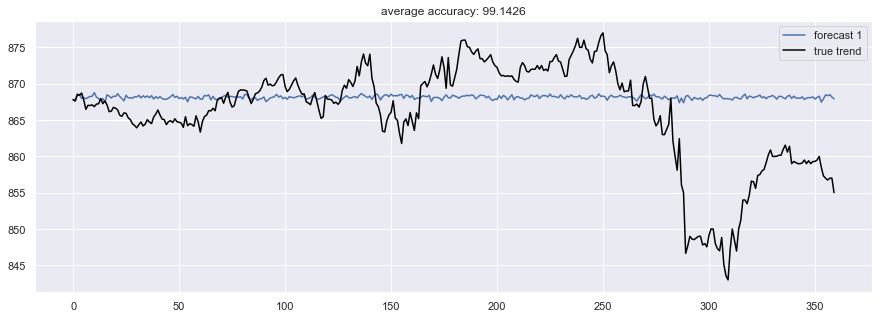

In [26]:
accuracies = [calculate_accuracy(df['4. close'].iloc[-test_size:].values, r) for r in results]

plt.figure(figsize = (15, 5))
for no, r in enumerate(results):
    plt.plot(r, label = 'forecast %d'%(no + 1))
plt.plot(df['4. close'].iloc[-test_size:].values, label = 'true trend', c = 'black')
plt.legend()
plt.title('average accuracy: %.4f'%(np.mean(accuracies)))
plt.show()

In [32]:
df['4. close'].iloc[-test_size:]

6942    867.7901
6943    867.6100
6944    868.5551
6945    868.4000
6946    868.7200
          ...   
7297    857.0000
7298    856.7500
7299    857.0000
7300    857.0100
7301    855.0100
Name: 4. close, Length: 360, dtype: float64

In [33]:
results

[[867.840042489989,
  867.7787235583248,
  868.4106271158569,
  868.5299959382837,
  867.9706801643326,
  868.0555481379654,
  867.9453263827954,
  868.0983855226018,
  868.2456075936734,
  868.2675326082012,
  868.7728910113774,
  868.1599728569065,
  867.9749359507985,
  867.6943451038994,
  867.964100110533,
  867.4392384084745,
  868.476831584959,
  868.2950594345829,
  868.0359161347269,
  868.2842095065208,
  868.2431705229217,
  868.6266940531891,
  868.2440343053336,
  867.9591277316445,
  867.632058218325,
  868.418274221815,
  868.0378003130268,
  868.0846350731124,
  868.0051288736872,
  868.227937685074,
  868.1839756757583,
  868.3998450216029,
  868.0440182927613,
  868.3489208258627,
  868.1215534926575,
  868.3224959452644,
  868.0755760501265,
  868.3566842150908,
  867.8956104587126,
  868.2253913921035,
  867.9908198026474,
  868.2235336861797,
  867.9606070151453,
  867.8555300980153,
  867.876105796013,
  868.008029128438,
  868.2026923038663,
  868.5094002268993,


In [34]:
df_train = df_log

In [35]:
tf.compat.v1.disable_eager_execution()
results = []
for i in range(simulation_size):
    print('simulation %d'%(i + 1))
    results.append(forecast())

simulation 1


train loop: 100%|███████████████████████████████████████████| 300/300 [21:04<00:00,  4.22s/it, acc=98.9, cost=0.000482]


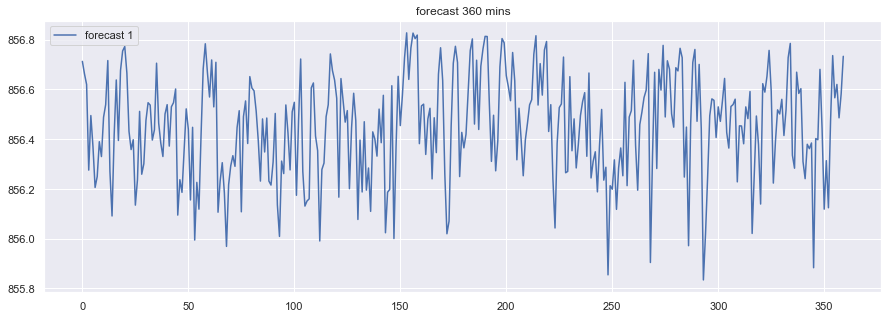

In [38]:
plt.figure(figsize = (15, 5))
for no, r in enumerate(results):
    plt.plot(r, label = 'forecast %d'%(no + 1))

plt.legend()
plt.title('forecast 360 mins')
plt.show()